# INTRODUCTION

A mega-online shopping mall provides different baby brands to customers. In order to optimize online advertisements throughout websites, they want to predict the view-to-click probability given the information below.

The data consists of:

Action: the “interaction” that users completed when online ad was exposed. There are two types of actions in this dataset, View (a.k.a Impression) or Click. (Reference: https://en.wikipedia.org/wiki/Impression_(online_media))
ID: unique user IDs
Action Time: the time when action (View/Click) happened, in microseconds format
Website: the website where the ad was published
Banner Size: the banner size of ad
Brand: the brand name that the ad was promoting
Colour: the colour of product showcased in the ad
Interaction Time: user’s interaction time with each ad (sec)

Goal: Predict the Likelihood of Click

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import pandas as pd
!pip install SQLAlchemy
!pip install pymysql
from sqlalchemy import create_engine
import pymysql
import configparser
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler,MinMaxScaler, RobustScaler
from sklearn.metrics import classification_report
from sklearn.model_selection import GridSearchCV
from imblearn.pipeline import make_pipeline,Pipeline
from sklearn.impute import SimpleImputer
from imblearn.over_sampling import RandomOverSampler
from sklearn.tree import DecisionTreeClassifier
from imblearn.under_sampling import RandomUnderSampler
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import confusion_matrix, accuracy_score, precision_recall_curve, f1_score, precision_score, recall_score

In [ ]:
## read data from ctrdata.csv
Origin = pd.read_csv('/content/drive/My Drive/website project/test3_data.csv')
Origin = Origin.set_index('Unnamed: 0')
Origin.head()

,ID,ActionTime,Action,Website,BannerSize,Brand,colour,InteractionTime
Unnamed: 0,,,,,,,,
1,AMsySZbNg8SBwPtj7IGHnip_8aY0,1508761859495365,View,Facebook,300x600,Carter's,Pink,0.171601
2,AMsySZZcUFNGOJs-lfC9j-ZDlV7Z,1502847469736117,View,Facebook,300x250,Burberry,Red,4.303945
3,AMsySZYoK8_bD0hGv4zu0iRn1TFo,1514169431528120,View,Facebook,728x90,Disney,Yellow,0.868106
4,AMsySZahxpwLOWnMJj6RGATgwEOc,1515527952591896,View,Facebook,320x50,Carter's,Yellow,0.802647
5,AMsySZbqgfMBDtAqZz1jVRaOmX00,1507514809374045,View,instagram.com,300x250,Gap,Gold,0.627148


# EDA & EXAMINATION

In [ ]:
## Convert outcomes to 1 or 0 
Origin['Action'] = Origin['Action'].replace({'View':0,'Click':1})
Origin.head()

,ID,ActionTime,Action,Website,BannerSize,Brand,colour,InteractionTime
Unnamed: 0,,,,,,,,
1,AMsySZbNg8SBwPtj7IGHnip_8aY0,1508761859495365,0,Facebook,300x600,Carter's,Pink,0.171601
2,AMsySZZcUFNGOJs-lfC9j-ZDlV7Z,1502847469736117,0,Facebook,300x250,Burberry,Red,4.303945
3,AMsySZYoK8_bD0hGv4zu0iRn1TFo,1514169431528120,0,Facebook,728x90,Disney,Yellow,0.868106
4,AMsySZahxpwLOWnMJj6RGATgwEOc,1515527952591896,0,Facebook,320x50,Carter's,Yellow,0.802647
5,AMsySZbqgfMBDtAqZz1jVRaOmX00,1507514809374045,0,instagram.com,300x250,Gap,Gold,0.627148


In [ ]:
## Detemine output, split testdata
from sklearn.model_selection import train_test_split
X = Origin.drop(columns=['Action'])
y = Origin['Action']

adX_train, adX_test, ady_train, ady_test = train_test_split(X, y, test_size=0.25)
adX_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 750000 entries, 237383 to 261038
Data columns (total 7 columns):
 #   Column           Non-Null Count   Dtype  
---  ------           --------------   -----  
 0   ID               750000 non-null  object 
 1   ActionTime       750000 non-null  int64  
 2   Website          750000 non-null  object 
 3   BannerSize       750000 non-null  object 
 4   Brand            750000 non-null  object 
 5   colour           750000 non-null  object 
 6   InteractionTime  749994 non-null  float64
dtypes: float64(1), int64(1), object(5)
memory usage: 45.8+ MB


In [ ]:
## Output distribution analysis
ady_train.value_counts(normalize=True)
## highly imbalance dataset

0    0.999753
1    0.000247
Name: Action, dtype: float64

In [ ]:
## Feature Examination: ID 
adX_train['ID'].value_counts().describe()

count    190474.000000
mean          3.937545
std          12.384725
min           1.000000
25%           1.000000
50%           2.000000
75%           3.000000
max        1690.000000
Name: ID, dtype: float64

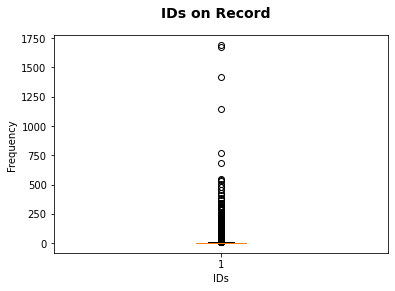

In [ ]:
## Feature Examination: ID  
data = adX_train['ID'].value_counts()
# Boxplot the count of IDs
fig = plt.figure()
fig.suptitle('IDs on Record', fontsize=14, fontweight='bold')

ax = fig.add_subplot(111)
ax.boxplot(data)

ax.set_xlabel('IDs')
ax.set_ylabel('Frequency')

plt.show(); 
## Base on the ID analysis, the times of ad viewing by different users range from 1 to almost 1750 times

In [ ]:
## Feature Examination: Datetime 
adX_train['ActionTime']
## the feature need to be converted to datime format

Unnamed: 0
237383    1516049073418306
176842    1507429701631939
654203    1503347737204640
431368    1506089339032971
147652    1503362023537131
                ...       
219114    1501290778704222
722605    1512847620637908
70996     1516929259462291
651441    1506301214493027
261038    1511409958350604
Name: ActionTime, Length: 750000, dtype: int64

In [ ]:
## Feature Examination: BannerSize 
adX_train['BannerSize'].value_counts().index
## Need to convert the data from string to size numbers

Index(['300x250', '728x90', 'Other', '320x50', '300x600', '160x600',
       '1200x627', '1x1', '320x480', '300x50', '320x100', '768x1024',
       '750x125', '1536x2048', 'other'],
      dtype='object')

In [ ]:
## Feature Examination: BannerSize 
# Convert Banner Size to area sizes, set size(other) to 0
adX_train['BannerSize'] = adX_train['BannerSize'].str.extract(r'(\d+)x').fillna(0).astype(int) * adX_train['BannerSize'].str.extract(r'x(\d+)').fillna(0).astype('int64')

## Convert 0 value to mean size value
Bannermean = adX_train['BannerSize'].mean()
adX_train['BannerSize'] = adX_train['BannerSize'].replace(0,Bannermean)

adX_train['BannerSize']


Unnamed: 0
237383     75000.000000
176842     75000.000000
654203    180000.000000
431368     75000.000000
147652     88564.078948
              ...      
219114    752400.000000
722605     65520.000000
70996      88564.078948
651441    752400.000000
261038     65520.000000
Name: BannerSize, Length: 750000, dtype: float64

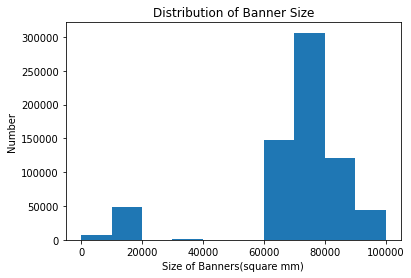

In [ ]:
plt.title('Distribution of Banner Size')
plt.xlabel('Size of Banners(square mm)')
plt.ylabel('Number')
plt.hist(adX_train['BannerSize'],range=(0,100000)); 
## The Sizes can be further classified

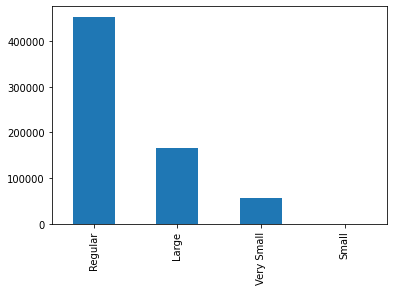

In [ ]:
## Classify the Banner to different categories in terms of banner sizes
data = adX_train['BannerSize']
size = [0, 40000, 65000, 80000, 100000]

## If the Banner size is 50000, this is a small size
size_category = ['Very Small', 'Small', 'Regular', 'Large']
adX_train['SizeLabel'] = pd.cut(data, bins=size, labels=size_category)
adX_train['SizeLabel'].value_counts().plot(kind='bar');

In [ ]:
## Feature Examination: Interaction Time
adX_train['InteractionTime'].describe()

count    749993.000000
mean          0.998348
std           0.998468
min           0.000002
25%           0.288682
50%           0.692997
75%           1.381895
max          12.617396
Name: InteractionTime, dtype: float64

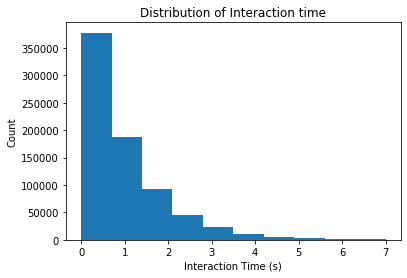

In [ ]:
## Feature Examination: Interaction Time

plt.title('Distribution of Interaction time')
plt.xlabel('Interaction Time (s)')
plt.ylabel('Count')
plt.hist(adX_train['InteractionTime'],range=(0,7));


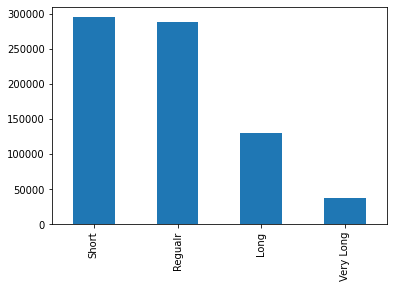

In [ ]:
## Feature Examination: Interaction Time
## Classify the Interactin time to different time length categories
data1 = adX_train['InteractionTime']
itime = [0, 0.5, 1.5, 3, 15]


Length_category = ['Short', 'Regualr', 'Long', 'Very Long']
adX_train['InteractionLength'] = pd.cut(data1, bins=itime, labels=Length_category)
adX_train['InteractionLength'].value_counts().plot(kind='bar');

In [ ]:
adX_train['Website'].value_counts()

Facebook         449879
Other             73167
Atedra            46241
instagram.com     42123
Craigslist.ca     29817
Yahoo             25202
TubeMogul         21491
Twitter           15956
Amazon            15435
Sympatico          8492
Kijiji             5825
Expedia            5246
Youtube            3884
Weather            3820
Wayfair            3005
AOL                 417
Name: Website, dtype: int64

In [ ]:
adX_train['Brand'].value_counts()

Carter's                166900
JoeFresh                143811
Old Navy                112992
Banana Republic          62973
Burberry                 62599
Disney                   62288
gymboree                 52624
Zara                     41800
Gap                      23035
The Children's Place     20978
Name: Brand, dtype: int64

# FEATURE ENGINEERING

In [ ]:
## Filling missing values
ITmean = adX_train['InteractionTime'].mean() 
adX_train['InteractionTime'] = adX_train['InteractionTime'].fillna(ITmean)

In [ ]:
## Datetime Engineering
## Convert ActionTime to regular timestamp
adX_train['ActionTime']=pd.to_datetime(adX_train['ActionTime'].astype('float64')/10**6, unit='s')
adX_train['ActionTime']

Unnamed: 0
237383   2018-01-15 20:44:33.418306048
176842   2017-10-08 02:28:21.631938816
654203   2017-08-21 20:35:37.204640000
431368   2017-09-22 14:08:59.032971008
147652   2017-08-22 00:33:43.537131008
                      ...             
219114   2017-07-29 01:12:58.704221952
722605   2017-12-09 19:27:00.637907968
70996    2018-01-26 01:14:19.462290944
651441   2017-09-25 01:00:14.493027072
261038   2017-11-23 04:05:58.350604032
Name: ActionTime, Length: 750000, dtype: datetime64[ns]

In [ ]:
## Classify the ActionTime timestamp to different seasons of a year
adX_train['month'] = pd.to_datetime(adX_train ['ActionTime']).dt.month
season = [-1, 3.1, 6.1, 9.1, 12.1]
## If the view action happen at 2:00 am, it is classified as late_night
season_name = ['Spring', 'Summer', 'Fall', 'Winter']
adX_train['Season'] = pd.cut(adX_train['month'], bins=season, labels=season_name)

## Classify the ActionTime timestamp to different periods of a day
adX_train['hr'] = pd.to_datetime(adX_train ['ActionTime']).dt.hour
time = [-1, 2.1, 6.1, 9.1, 11.1, 19.1, 24]
## If the view action happen at 2:00 am, it is classified as late_night
time_name = ['late_night', 'early_morning', 'morning', 'noon', 'afternoon', 'evening']
adX_train['Daysection'] = pd.cut(adX_train['hr'], bins=time, labels=time_name)


## Classify the ActionTime timestamp to either a weekday or weekend
def wd(a):
    if a==5 or a==6:
        b='weekend'
    else:
        b='weekday'
    return b

adX_train['Dayofweek'] = pd.to_datetime(adX_train ['ActionTime']).dt.dayofweek.apply(wd)
adX_train['Dayofweek']


Unnamed: 0
237383    weekday
176842    weekend
654203    weekday
431368    weekday
147652    weekday
           ...   
219114    weekend
722605    weekend
70996     weekday
651441    weekday
261038    weekday
Name: Dayofweek, Length: 750000, dtype: object

In [ ]:
adX_train

,ID,ActionTime,Website,BannerSize,Brand,colour,InteractionTime,SizeLabel,InteractionLength,month,Season,hr,Daysection,Dayofweek
Unnamed: 0,,,,,,,,,,,,,,
10489,AMsySZaxbwbdR4AKM5MM2NVOsHkE,2018-01-12 20:02:27.989335040,Twitter,153600.000000,gymboree,Pink,0.692188,NaN,Regualr,1,Spring,20,evening,weekday
552198,AMsySZZeW1ZaWpx7ewHXKL7yyzbv,2017-11-02 16:19:30.251171072,Facebook,75000.000000,Carter's,Yellow,0.115876,Regular,Short,11,Winter,16,afternoon,weekday
577197,AMsySZar598RCC3zk5bDZkQ4x8NB,2017-10-10 20:35:34.761758208,Facebook,75000.000000,JoeFresh,Pink,2.538259,Regular,Long,10,Winter,20,evening,weekday
479110,AMsySZa5nfK7RLsyYxtfYvLn6nQN,2017-10-14 11:47:12.116802816,Facebook,75000.000000,JoeFresh,Blue,0.279693,Regular,Short,10,Winter,11,noon,weekend
864636,AMsySZb663JTGCvBOLtaJ9LzS7_f,2017-10-29 15:40:19.291250944,Facebook,65520.000000,Old Navy,Pink,1.145405,Regular,Regualr,10,Winter,15,afternoon,weekend
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
741827,AMsySZbJLksooK55Bpu9k2WD6pCI,2018-01-26 08:25:57.401341952,instagram.com,88499.818595,JoeFresh,Yellow,0.486535,Large,Short,1,Spring,8,morning,weekday
178083,AMsySZZDnX05jmn5S35PT_QFMt4o,2017-11-11 12:36:13.595802112,Facebook,65520.000000,Burberry,Pink,4.616843,Regular,Very Long,11,Winter,12,afternoon,weekend
537453,AMsySZYtWhBcdx0KWueHZAJHZa-t,2017-09-23 07:33:04.204067072,instagram.com,75000.000000,Carter's,Pink,0.075972,Regular,Short,9,Fall,7,morning,weekend


# ODINAL FEATURE ENGINEERING

In [ ]:
## Self odinal engineering
X_train = adX_train.copy()
y_train = ady_train.copy()

prob = X_train['ID'].value_counts(normalize=True).to_dict()
X_train['ID_prob'] = X_train['ID'].map(prob)


X_train = X_train[['ID_prob', 'InteractionTime', 'Website', 'Season', 'BannerSize', 'Brand', 'colour', 'Dayofweek', 'Daysection']]
X_train['click']=ady_train
X_train.head()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  # Remove the CWD from sys.path while we load stuff.


,ID_prob,InteractionTime,Website,Season,BannerSize,Brand,colour,Dayofweek,Daysection,click
Unnamed: 0,,,,,,,,,,
10489,0.000011,0.692188,Twitter,Spring,153600.0,gymboree,Pink,weekday,evening,0
552198,0.000005,0.115876,Facebook,Winter,75000.0,Carter's,Yellow,weekday,afternoon,0
577197,0.000244,2.538259,Facebook,Winter,75000.0,JoeFresh,Pink,weekday,evening,0
479110,0.000003,0.279693,Facebook,Winter,75000.0,JoeFresh,Blue,weekend,noon,0
864636,0.000016,1.145405,Facebook,Winter,65520.0,Old Navy,Pink,weekend,afternoon,0


In [ ]:
import numpy as np
# rate function
def rate_calculation(x):
    """Calculate the attributed rate. Scale by confidence"""
    rate = x.sum() / float(ady_train.sum())
    ##conf = np.min([1, np.log10(x.count()) / log_group])
    return rate

# prob function
def prob_calculation(x):
    """Calculate the attributed rate. Scale by confidence""" 
    prob = x.count()/X_train.shape[0]
    return prob


In [ ]:
ady_train.sum()

197

In [ ]:
X_train = X_train[['ID_prob', 'InteractionTime', 'Website', 'Season', 'BannerSize', 'Brand', 'colour', 'Dayofweek', 'Daysection']]
X_train['click']=ady_train

ATTRIBUTION_CATEGORIES = [        
    # V1 Features #
    ###############
   ['Website'], ['Season'], ['BannerSize'], ['Brand'], ['colour'], ['Dayofweek'], ['Daysection'],
    
    # V2 Features #
    ###############
    ['Website', 'Brand'],
    ['Website', 'Dayofweek'],
    ['Website', 'Season'],
    ['Website', 'Daysection'],
    ['Website', 'BannerSize'],
    
    # V3 Features #
    ###############
    
    ['Website', 'Brand','Season'],
    ['Website', 'Brand','BannerSize'],
    ['Website', 'Brand','Daysection'],
    ['Website', 'Brand','colour'],
    
]


# Find frequency of is_attributed for each unique value in column
freqs = {}
for cols in ATTRIBUTION_CATEGORIES:
    
    # New feature name
    new_feature = '_'.join(cols)+'_confRate'    
    
    # Perform the groupby
    group_object = X_train.groupby(cols)
    
    # Group sizes    
    group_sizes = group_object.size()
    log_group = np.log10(10000) # 100 views -> 50% confidence, 10 views -> 25% confidence 
    print(">> Calculating confidence-weighted rate for: {}.\n   Saving to: {}. Group Max /Mean / Median / Min: {} / {} / {} / {}".format(
        cols, new_feature, 
        group_sizes.max(), 
        np.round(group_sizes.mean(), 2),
        np.round(group_sizes.median(), 2),
        group_sizes.min()
    ))
    
    # Perform the merge
    X_train = X_train.merge(
        group_object['click']. \
            apply(rate_calculation). \
            reset_index(). \
            rename( 
                index=str,
                columns={'click': new_feature}
            )[cols + [new_feature]],
        on=cols, how='left'
    )
    
    # New feature name2
    new_feature2 = '_'.join(cols)+'_prob'

    # Perform the groupby
    group_object = X_train.groupby(cols)

    # Perform the merge
    X_train = X_train.merge(
        group_object['click']. \
            apply(prob_calculation). \
            reset_index(). \
            rename( 
                index=str,
                columns={'click': new_feature2}
            )[cols + [new_feature2]],
        on=cols, how='left'
    )

X_train.head()

>> Calculating confidence-weighted rate for: ['Website'].
   Saving to: Website_confRate. Group Max /Mean / Median / Min: 449863 / 46875.0 / 15659.5 / 433
>> Calculating confidence-weighted rate for: ['Season'].
   Saving to: Season_confRate. Group Max /Mean / Median / Min: 347222 / 187500.0 / 201389.0 / 0
>> Calculating confidence-weighted rate for: ['BannerSize'].
   Saving to: BannerSize_confRate. Group Max /Mean / Median / Min: 306290 / 53571.43 / 15535.5 / 236
>> Calculating confidence-weighted rate for: ['Brand'].
   Saving to: Brand_confRate. Group Max /Mean / Median / Min: 166900 / 75000.0 / 62443.5 / 20978
>> Calculating confidence-weighted rate for: ['colour'].
   Saving to: colour_confRate. Group Max /Mean / Median / Min: 242246 / 107142.86 / 103586.0 / 34406
>> Calculating confidence-weighted rate for: ['Dayofweek'].
   Saving to: Dayofweek_confRate. Group Max /Mean / Median / Min: 551697 / 375000.0 / 375000.0 / 198303
>> Calculating confidence-weighted rate for: ['Daysecti

,ID_prob,InteractionTime,Website,Season,BannerSize,Brand,colour,Dayofweek,Daysection,click,Website_confRate,Website_prob,Season_confRate,Season_prob,BannerSize_confRate,BannerSize_prob,Brand_confRate,Brand_prob,colour_confRate,colour_prob,Dayofweek_confRate,Dayofweek_prob,Daysection_confRate,Daysection_prob,Website_Brand_confRate,Website_Brand_prob,Website_Dayofweek_confRate,Website_Dayofweek_prob,Website_Season_confRate,Website_Season_prob,Website_Daysection_confRate,Website_Daysection_prob,Website_BannerSize_confRate,Website_BannerSize_prob,Website_Brand_Season_confRate,Website_Brand_Season_prob,Website_Brand_BannerSize_confRate,Website_Brand_BannerSize_prob,Website_Brand_Daysection_confRate,Website_Brand_Daysection_prob,Website_Brand_colour_confRate,Website_Brand_colour_prob
0,0.000011,0.692188,Twitter,Spring,153600.0,gymboree,Pink,weekday,evening,0,0.000000,0.021127,0.243655,0.131056,0.000000,0.007096,0.086294,0.070165,0.304569,0.322995,0.862944,0.735596,0.238579,0.219281,0.000000,0.001496,0.000000,0.015129,0.000000,0.002512,0.000000,0.004936,0.000000,0.005784,0.000000,0.000173,0.000000,0.000412,0.000000,0.000341,0.000000,0.000479
1,0.000005,0.115876,Facebook,Winter,75000.0,Carter's,Yellow,weekday,afternoon,0,0.670051,0.599817,0.563452,0.462963,0.324873,0.408387,0.238579,0.222533,0.177665,0.184536,0.862944,0.735596,0.522843,0.385948,0.162437,0.133353,0.593909,0.436847,0.370558,0.319404,0.350254,0.221221,0.269036,0.303517,0.081218,0.071056,0.065990,0.067211,0.091371,0.049048,0.035533,0.024599
2,0.000244,2.538259,Facebook,Winter,75000.0,JoeFresh,Pink,weekday,evening,0,0.670051,0.599817,0.563452,0.462963,0.324873,0.408387,0.172589,0.191748,0.304569,0.322995,0.862944,0.735596,0.238579,0.219281,0.086294,0.115036,0.593909,0.436847,0.370558,0.319404,0.157360,0.134260,0.269036,0.303517,0.045685,0.061168,0.040609,0.058367,0.015228,0.025803,0.035533,0.037097
3,0.000003,0.279693,Facebook,Winter,75000.0,JoeFresh,Blue,weekend,noon,0,0.670051,0.599817,0.563452,0.462963,0.324873,0.408387,0.172589,0.191748,0.152284,0.138115,0.137056,0.264404,0.015228,0.045067,0.086294,0.115036,0.076142,0.162971,0.370558,0.319404,0.005076,0.020156,0.269036,0.303517,0.045685,0.061168,0.040609,0.058367,0.000000,0.003885,0.010152,0.015943
4,0.000016,1.145405,Facebook,Winter,65520.0,Old Navy,Pink,weekend,afternoon,0,0.670051,0.599817,0.563452,0.462963,0.187817,0.196060,0.162437,0.150656,0.304569,0.322995,0.137056,0.264404,0.522843,0.385948,0.106599,0.090277,0.076142,0.162971,0.370558,0.319404,0.350254,0.221221,0.152284,0.139244,0.060914,0.048187,0.045685,0.020781,0.055838,0.033336,0.055838,0.029080


In [ ]:
X_train = X_train.drop(columns=['InteractionTime','click', 'Website', 'Season', 'BannerSize', 'Brand', 'colour', 'Dayofweek', 'Daysection'])

In [ ]:
X_train.shape

(750000, 33)

In [ ]:
X_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 750000 entries, 0 to 749999
Data columns (total 33 columns):
 #   Column                             Non-Null Count   Dtype  
---  ------                             --------------   -----  
 0   ID_prob                            750000 non-null  float64
 1   Website_confRate                   750000 non-null  float64
 2   Website_prob                       750000 non-null  float64
 3   Season_confRate                    750000 non-null  float64
 4   Season_prob                        750000 non-null  float64
 5   BannerSize_confRate                750000 non-null  float64
 6   BannerSize_prob                    750000 non-null  float64
 7   Brand_confRate                     750000 non-null  float64
 8   Brand_prob                         750000 non-null  float64
 9   colour_confRate                    750000 non-null  float64
 10  colour_prob                        750000 non-null  float64
 11  Dayofweek_confRate                 7500

# FEATURE SELECTION

In [ ]:
from sklearn.preprocessing import RobustScaler
from sklearn.preprocessing import OneHotEncoder 
oh = OneHotEncoder() 
ros = RandomOverSampler(random_state=42,sampling_strategy=0.3)
rs = RobustScaler(with_centering=False)



In [ ]:
from sklearn.preprocessing import RobustScaler
rs = RobustScaler()
ros = RandomOverSampler(random_state=42,sampling_strategy=0.3)
X_resembled,y_resembled = ros.fit_resample(X_train.copy(),y_train.copy()) ## oversampling

y_xg = y_resembled
X_xg = pd.DataFrame(rs.fit_transform(X_resembled),columns=X_resembled.columns) ## robust scaler

X_xg.head()

,ID_prob,Website_confRate,Website_prob,Season_confRate,Season_prob,BannerSize_confRate,BannerSize_prob,Brand_confRate,Brand_prob,colour_confRate,colour_prob,Dayofweek_confRate,Dayofweek_prob,Daysection_confRate,Daysection_prob,Website_Brand_confRate,Website_Brand_prob,Website_Dayofweek_confRate,Website_Dayofweek_prob,Website_Season_confRate,Website_Season_prob,Website_Daysection_confRate,Website_Daysection_prob,Website_BannerSize_confRate,Website_BannerSize_prob,Website_Brand_Season_confRate,Website_Brand_Season_prob,Website_Brand_BannerSize_confRate,Website_Brand_BannerSize_prob,Website_Brand_Daysection_confRate,Website_Brand_Daysection_prob,Website_Brand_colour_confRate,Website_Brand_colour_prob
0,0.000000,-1.056,-1.075156,0.000000,-4.824832,-0.860465,-0.546149,-0.681818,-0.740503,0.833333,0.748911,0.000000,0.000000,0.000000,0.000000,-0.600000,-0.494661,-0.180180,-0.372777,-0.220588,-0.373179,-0.196970,-0.440653,-0.224490,-0.132045,-0.428571,-0.620602,-0.333333,-0.269735,-0.4,-0.422660,-0.333333,-0.391958
1,-0.190476,0.000,0.000000,0.863014,1.000000,0.627907,0.613673,0.681818,0.661261,0.000000,0.000000,0.000000,0.000000,0.674699,0.717723,1.533333,1.110067,0.873874,0.690569,0.852941,0.731590,0.848485,0.601164,0.857143,0.936274,1.857143,2.533852,1.833333,2.598145,3.2,2.233874,2.000000,1.257385
2,8.333333,0.000,0.000000,0.863014,1.000000,0.627907,0.613673,0.090909,0.378041,0.833333,0.748911,0.000000,0.000000,0.000000,0.000000,0.533333,0.887142,0.873874,0.690569,0.852941,0.731590,0.272727,0.182283,0.857143,0.936274,0.857143,2.093811,1.000000,2.218444,0.2,0.966039,2.000000,2.112053
3,-0.285714,0.000,0.000000,0.863014,1.000000,0.627907,0.613673,0.090909,0.378041,-0.166667,-0.251089,-0.725888,-0.471192,-0.530120,-0.750227,0.533333,0.887142,-0.045045,0.000000,0.852941,0.731590,-0.181818,-0.367340,0.857143,0.936274,0.857143,2.093811,1.000000,2.218444,-0.4,-0.229365,0.333333,0.665481
4,0.190476,0.000,0.000000,0.863014,1.000000,0.000000,0.000000,0.000000,0.000000,0.833333,0.748911,-0.725888,-0.471192,0.674699,0.717723,0.800000,0.585824,-0.045045,0.000000,0.852941,0.731590,0.848485,0.601164,0.387755,0.346833,1.285714,1.516110,1.166667,0.604786,1.8,1.376918,3.333333,1.563822


In [ ]:
# Create a XGboost model
from xgboost import XGBClassifier
# Params from: https://www.kaggle.com/aharless/swetha-s-xgboost-revised
clf_xgBoost = XGBClassifier(
    max_depth = 4,
    subsample = 0.8,
    colsample_bytree = 0.7,
    colsample_bylevel = 0.7,
    scale_pos_weight = 9,
    min_child_weight = 0,
    reg_alpha = 4,
    n_jobs = 4, 
    objective = 'binary:logistic'
)
# Fit the models
clf_xgBoost.fit(X_xg, y_xg)

XGBClassifier(colsample_bylevel=0.7, colsample_bytree=0.7, max_depth=4,
              min_child_weight=0, n_jobs=4, reg_alpha=4, scale_pos_weight=9,
              subsample=0.8)

In [ ]:
X_xg.columns

Index(['ID_prob', 'Website_confRate', 'Website_prob', 'Season_confRate',
       'Season_prob', 'BannerSize_confRate', 'BannerSize_prob',
       'Brand_confRate', 'Brand_prob', 'colour_confRate', 'colour_prob',
       'Dayofweek_confRate', 'Dayofweek_prob', 'Daysection_confRate',
       'Daysection_prob', 'Website_Brand_confRate', 'Website_Brand_prob',
       'Website_Dayofweek_confRate', 'Website_Dayofweek_prob',
       'Website_Season_confRate', 'Website_Season_prob',
       'Website_Daysection_confRate', 'Website_Daysection_prob',
       'Website_BannerSize_confRate', 'Website_BannerSize_prob',
       'Website_Brand_Season_confRate', 'Website_Brand_Season_prob',
       'Website_Brand_BannerSize_confRate', 'Website_Brand_BannerSize_prob',
       'Website_Brand_Daysection_confRate', 'Website_Brand_Daysection_prob',
       'Website_Brand_colour_confRate', 'Website_Brand_colour_prob'],
      dtype='object')

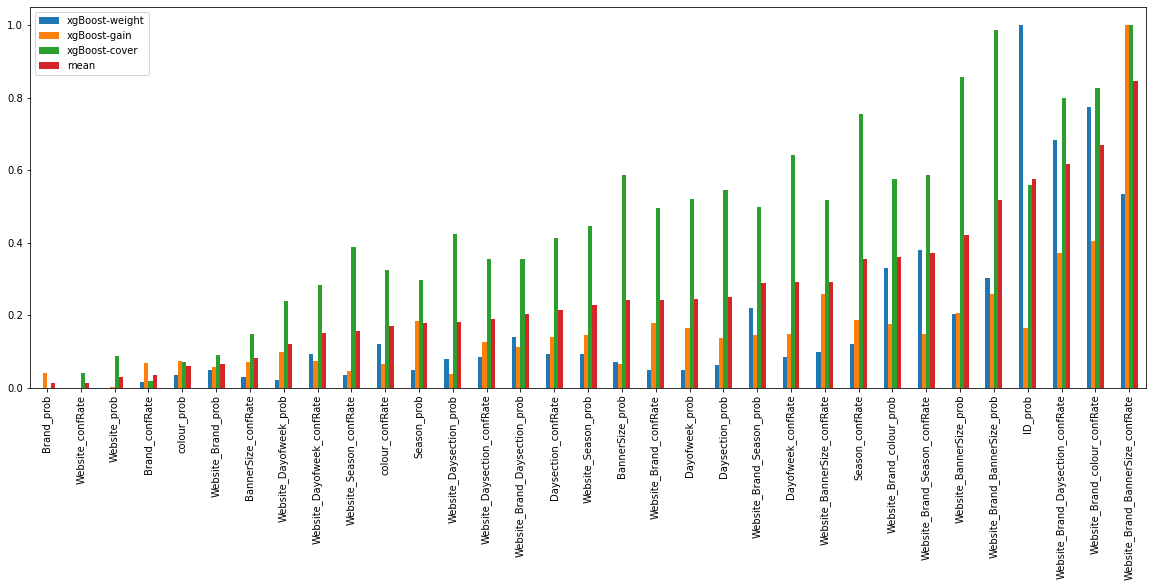

In [ ]:
from sklearn import preprocessing

# Get xgBoost importances
importance_dict = {}
for import_type in ['weight', 'gain', 'cover']:
    importance_dict['xgBoost-'+import_type] = clf_xgBoost.get_booster().get_score(importance_type=import_type)
    
# MinMax scale all importances
importance_df = pd.DataFrame(importance_dict).fillna(0)
importance_df = pd.DataFrame(
    preprocessing.MinMaxScaler().fit_transform(importance_df),
    columns=importance_df.columns,
    index=importance_df.index
)

# Create mean column
importance_df['mean'] = importance_df.mean(axis=1)

# Plot the feature importances
importance_df.sort_values('mean').plot(kind='bar', figsize=(20, 7))

In [ ]:
importance_df.sort_values('mean').index

Index(['Brand_prob', 'Website_confRate', 'Website_prob', 'Brand_confRate',
       'colour_prob', 'Website_Brand_prob', 'BannerSize_confRate',
       'Website_Dayofweek_prob', 'Website_Dayofweek_confRate',
       'Website_Season_confRate', 'colour_confRate', 'Season_prob',
       'Website_Daysection_prob', 'Website_Daysection_confRate',
       'Website_Brand_Daysection_prob', 'Daysection_confRate',
       'Website_Season_prob', 'BannerSize_prob', 'Website_Brand_confRate',
       'Dayofweek_prob', 'Daysection_prob', 'Website_Brand_Season_prob',
       'Dayofweek_confRate', 'Website_BannerSize_confRate', 'Season_confRate',
       'Website_Brand_colour_prob', 'Website_Brand_Season_confRate',
       'Website_BannerSize_prob', 'Website_Brand_BannerSize_prob', 'ID_prob',
       'Website_Brand_Daysection_confRate', 'Website_Brand_colour_confRate',
       'Website_Brand_BannerSize_confRate'],
      dtype='object')

In [ ]:
X_train1 = X_train[['Website_Brand_prob', 'Season_confRate',
       'Daysection_confRate', 'Website_BannerSize_prob', 'Website_Season_prob',
       'Website_Brand_Season_confRate', 'Website_Brand_Season_prob',
       'Website_Brand_colour_prob', 'Website_Brand_BannerSize_prob', 'ID_prob',
       'Website_Brand_Daysection_confRate',
       'Website_Brand_BannerSize_confRate', 'Website_Brand_colour_confRate']]
X_train1.head()

,Website_Brand_prob,Season_confRate,Daysection_confRate,Website_BannerSize_prob,Website_Season_prob,Website_Brand_Season_confRate,Website_Brand_Season_prob,Website_Brand_colour_prob,Website_Brand_BannerSize_prob,ID_prob,Website_Brand_Daysection_confRate,Website_Brand_BannerSize_confRate,Website_Brand_colour_confRate
0,0.001496,0.243655,0.238579,0.005784,0.002512,0.000000,0.000173,0.000479,0.000412,0.000011,0.000000,0.000000,0.000000
1,0.133353,0.563452,0.522843,0.303517,0.319404,0.081218,0.071056,0.024599,0.067211,0.000005,0.091371,0.065990,0.035533
2,0.115036,0.563452,0.238579,0.303517,0.319404,0.045685,0.061168,0.037097,0.058367,0.000244,0.015228,0.040609,0.035533
3,0.115036,0.563452,0.015228,0.303517,0.319404,0.045685,0.061168,0.015943,0.058367,0.000003,0.000000,0.040609,0.010152
4,0.090277,0.563452,0.522843,0.139244,0.319404,0.060914,0.048187,0.029080,0.020781,0.000016,0.055838,0.045685,0.055838


# TEST SET TRANSFORMATION

In [ ]:

def FeatureEngineering(X):
    ## Classify the ActionTime timestamp to different seasons of a year
    X['month'] = pd.to_datetime(X ['ActionTime']).dt.month
    season = [-1, 3.1, 6.1, 9.1, 12.1]
    ## If the view action happen at 2:00 am, it is classified as late_night
    season_name = ['Spring', 'Summer', 'Fall', 'Winter']
    X['Season'] = pd.cut(X['month'], bins=season, labels=season_name)

    ## Classify the ActionTime timestamp to different periods of a day
    X['hr'] = pd.to_datetime(X ['ActionTime']).dt.hour
    time = [-1, 2.1, 6.1, 9.1, 11.1, 19.1, 24]
    ## If the view action happen at 2:00 am, it is classified as late_night
    time_name = ['late_night', 'early_morning', 'morning', 'noon', 'afternoon', 'evening']
    X['Daysection'] = pd.cut(X['hr'], bins=time, labels=time_name)

    ## Feature Examination: BannerSize 
    # Convert Banner Size to area sizes, set size(other) to 0
    X['BannerSize'] = X['BannerSize'].str.extract(r'(\d+)x').fillna(0).astype(int) * X['BannerSize'].str.extract(r'x(\d+)').fillna(0).astype('int64')

    ## Convert 0 value to mean size value
    Bannermean = X['BannerSize'].mean()
    X['BannerSize'] = X['BannerSize'].replace(0,Bannermean)

    ## Classify the ActionTime timestamp to either a weekday or weekend
    def wd(a):
        if a==5 or a==6:
            b='weekend'
        else:
            b='weekday'
        return b

    X['Dayofweek'] = pd.to_datetime(X['ActionTime']).dt.dayofweek.apply(wd)
    
    return X

In [ ]:
## Self odinal engineering
X_test = FeatureEngineering(adX_test).copy()
y_test = ady_test.copy()

prob = X_test['ID'].value_counts(normalize=True).to_dict()
X_test['ID_prob'] = X_test['ID'].map(prob)


X_test.shape

(250000, 13)

In [ ]:
X_test.columns

Index(['ID', 'ActionTime', 'Website', 'BannerSize', 'Brand', 'colour',
       'InteractionTime', 'month', 'Season', 'hr', 'Daysection', 'Dayofweek',
       'ID_prob'],
      dtype='object')

In [ ]:
## Self odinal engineering
X_t = adX_train.copy()
y_t = ady_train.copy()

prob = X_t['ID'].value_counts(normalize=True).to_dict()
X_t['ID_prob'] = X_t['ID'].map(prob)


X_t = X_t[['ID_prob', 'InteractionTime', 'Website', 'Season', 'BannerSize', 'Brand', 'colour', 'Dayofweek', 'Daysection']]
X_t['click']=ady_train
X_t.head()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  # Remove the CWD from sys.path while we load stuff.


,ID_prob,InteractionTime,Website,Season,BannerSize,Brand,colour,Dayofweek,Daysection,click
Unnamed: 0,,,,,,,,,,
10489,0.000011,0.692188,Twitter,Spring,153600.0,gymboree,Pink,weekday,evening,0
552198,0.000005,0.115876,Facebook,Winter,75000.0,Carter's,Yellow,weekday,afternoon,0
577197,0.000244,2.538259,Facebook,Winter,75000.0,JoeFresh,Pink,weekday,evening,0
479110,0.000003,0.279693,Facebook,Winter,75000.0,JoeFresh,Blue,weekend,noon,0
864636,0.000016,1.145405,Facebook,Winter,65520.0,Old Navy,Pink,weekend,afternoon,0


In [ ]:
X_test = X_test[['ID_prob', 'InteractionTime', 'Website', 'Season', 'BannerSize', 'Brand', 'colour', 'Dayofweek', 'Daysection']]
# rate function
def rate_calculation_t(x):
    """Calculate the attributed rate. Scale by confidence"""
    rate = x.sum() / float(ady_train.sum())
    ## conf = np.min([1, np.log10(x.count()) / log_group])
    return rate 

# prob function
def prob_calculation_t(x):
    """Calculate the attributed rate. Scale by confidence""" 
    prob = x.count()/X_test.shape[0]
    return prob

ATTRIBUTION_CATEGORIES = [        
     # V1 Features #
    ###############
   ['Website'], ['Season'], ['BannerSize'], ['Brand'], ['colour'], ['Dayofweek'], ['Daysection'],
    
    # V2 Features #
    ###############
    ['Website', 'Brand'],
    ['Website', 'Dayofweek'],
    ['Website', 'Season'],
    ['Website', 'Daysection'],
    ['Website', 'BannerSize'],
    
    # V3 Features #
    ###############
    
    ['Website', 'Brand','Season'],
    ['Website', 'Brand','BannerSize'],
    ['Website', 'Brand','Daysection'],
    ['Website', 'Brand','colour'],
    
]


# Find frequency of is_attributed for each unique value in column
freqs = {}
for cols in ATTRIBUTION_CATEGORIES:
    
    # New feature name
    new_feature = '_'.join(cols)+'_confRate'    
    
    # Perform the groupby
    group_object = X_t.groupby(cols)
    
    
    # Perform the merge
    X_test = X_test.merge(
        group_object['click']. \
            apply(rate_calculation_t). \
            reset_index(). \
            rename( 
                index=str,
                columns={'click': new_feature}
            )[cols + [new_feature]],
        on=cols, how='left'
    )
    
    # New feature name2
    new_feature2 = '_'.join(cols)+'_prob'

    # Perform the groupby
    group_object = X_test.groupby(cols)

    # Perform the merge
    X_test = X_test.merge(
        group_object['InteractionTime']. \
            apply(prob_calculation_t). \
            reset_index(). \
            rename( 
                index=str,
                columns={'InteractionTime': new_feature2}
            )[cols + [new_feature2]],
        on=cols, how='left'
    )

X_test.head()

,ID_prob,InteractionTime,Website,Season,BannerSize,Brand,colour,Dayofweek,Daysection,Website_confRate,Website_prob,Season_confRate,Season_prob,BannerSize_confRate,BannerSize_prob,Brand_confRate,Brand_prob,colour_confRate,colour_prob,Dayofweek_confRate,Dayofweek_prob,Daysection_confRate,Daysection_prob,Website_Brand_confRate,Website_Brand_prob,Website_Dayofweek_confRate,Website_Dayofweek_prob,Website_Season_confRate,Website_Season_prob,Website_Daysection_confRate,Website_Daysection_prob,Website_BannerSize_confRate,Website_BannerSize_prob,Website_Brand_Season_confRate,Website_Brand_Season_prob,Website_Brand_BannerSize_confRate,Website_Brand_BannerSize_prob,Website_Brand_Daysection_confRate,Website_Brand_Daysection_prob,Website_Brand_colour_confRate,Website_Brand_colour_prob
0,0.000048,0.970806,Amazon,Spring,88875.847068,JoeFresh,Gold,weekend,noon,0.030457,0.020508,0.243655,0.999996,NaN,0.162548,0.172589,0.191640,0.172589,0.161776,0.137056,0.999996,0.015228,0.555152,0.015228,0.003968,0.005076,0.020508,0.00000,0.020508,0.000000,0.009716,NaN,0.011568,0.000000,0.003968,NaN,0.002252,0.000000,0.001924,0.010152,0.000680
1,0.000012,0.204016,Wayfair,Spring,75000.000000,Carter's,Pink,weekend,afternoon,0.005076,0.004016,0.243655,0.999996,0.324873,0.409660,0.238579,0.222940,0.304569,0.322360,0.137056,0.999996,0.522843,0.225988,0.005076,0.000892,0.000000,0.004016,NaN,0.004016,0.000000,0.002532,0.000000,0.000408,NaN,0.000892,0.000000,0.000112,0.000000,0.000548,0.000000,0.000264
2,0.000016,0.514060,Facebook,Spring,65520.000000,Disney,Pink,weekend,afternoon,0.670051,0.601092,0.243655,0.999996,0.187817,0.196696,0.055838,0.083668,0.304569,0.322360,0.137056,0.999996,0.522843,0.225988,0.045685,0.050716,0.076142,0.601092,0.22335,0.601092,0.350254,0.189340,0.152284,0.139936,0.015228,0.050716,0.000000,0.011704,0.030457,0.015724,0.010152,0.016140
3,0.000008,0.118706,Facebook,Spring,75000.000000,JoeFresh,Yellow,weekend,afternoon,0.670051,0.601092,0.243655,0.999996,0.324873,0.409660,0.172589,0.191640,0.177665,0.182920,0.137056,0.999996,0.522843,0.225988,0.086294,0.115596,0.076142,0.601092,0.22335,0.601092,0.350254,0.189340,0.269036,0.305176,0.025381,0.115596,0.040609,0.058924,0.040609,0.036536,0.005076,0.021420
4,0.000024,0.665837,Facebook,Spring,75000.000000,Burberry,other,weekend,noon,0.670051,0.601092,0.243655,0.999996,0.324873,0.409660,0.081218,0.082988,0.060914,0.046368,0.137056,0.999996,0.015228,0.555152,0.071066,0.049812,0.076142,0.601092,0.22335,0.601092,0.005076,0.350476,0.269036,0.305176,0.025381,0.049812,0.030457,0.025128,0.000000,0.028900,0.000000,0.002292


In [ ]:
## Select the high impact features
X_test1 = X_test.copy()[['Website_Brand_prob', 'Season_confRate',
       'Daysection_confRate', 'Website_BannerSize_prob', 'Website_Season_prob',
       'Website_Brand_Season_confRate', 'Website_Brand_Season_prob',
       'Website_Brand_colour_prob', 'Website_Brand_BannerSize_prob', 'ID_prob',
       'Website_Brand_Daysection_confRate',
       'Website_Brand_BannerSize_confRate', 'Website_Brand_colour_confRate']].fillna(0)
X_test1

,Website_Brand_prob,Season_confRate,Daysection_confRate,Website_BannerSize_prob,Website_Season_prob,Website_Brand_Season_confRate,Website_Brand_Season_prob,Website_Brand_colour_prob,Website_Brand_BannerSize_prob,ID_prob,Website_Brand_Daysection_confRate,Website_Brand_BannerSize_confRate,Website_Brand_colour_confRate
0,0.003968,0.243655,0.015228,0.011568,0.020508,0.000000,0.003968,0.000680,0.002252,0.000048,0.000000,0.000000,0.010152
1,0.000892,0.243655,0.522843,0.000408,0.004016,0.000000,0.000892,0.000264,0.000112,0.000012,0.000000,0.000000,0.000000
2,0.050716,0.243655,0.522843,0.139936,0.601092,0.015228,0.050716,0.016140,0.011704,0.000016,0.030457,0.000000,0.010152
3,0.115596,0.243655,0.522843,0.305176,0.601092,0.025381,0.115596,0.021420,0.058924,0.000008,0.040609,0.040609,0.005076
4,0.049812,0.243655,0.015228,0.305176,0.601092,0.025381,0.049812,0.002292,0.025128,0.000024,0.000000,0.030457,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...
249995,0.021864,0.243655,0.522843,0.000332,0.096628,0.000000,0.021864,0.003980,0.000084,0.000084,0.020305,0.000000,0.000000
249996,0.007684,0.243655,0.050761,0.027524,0.034072,0.000000,0.007684,0.001468,0.006208,0.000028,0.000000,0.000000,0.000000
249997,0.133016,0.243655,0.050761,0.305176,0.601092,0.065990,0.133016,0.042780,0.067192,0.000280,0.015228,0.065990,0.050761
249998,0.004808,0.243655,0.050761,0.024928,0.055944,0.000000,0.004808,0.000896,0.002036,0.000420,0.005076,0.000000,0.000000


In [ ]:
X_train1.head()

,Brand_prob,ID_Website_confRate,ID_BannerSize_confRate,ID_confRate,ID_Brand_confRate,ID_colour_confRate,ID_Dayofweek_prob,ID_prob,ID_Dayofweek_confRate,ID_Website_prob,ID_Daysection_confRate,ID_BannerSize_prob,ID_Daysection_prob,ID_colour_prob,ID_Brand_prob
0,0.188027,0.359493,0.249534,0.362200,0.197473,0.168441,0.000073,0.000073,0.362200,0.000068,0.158110,0.000041,0.000012,0.000013,0.000016
1,0.084920,0.127838,0.070279,0.127838,0.086976,0.000000,0.000006,0.000007,0.069759,0.000007,0.094064,0.000005,0.000004,0.000001,0.000002
2,0.029171,0.401289,0.296607,0.398085,0.000000,0.178984,0.000002,0.000045,0.078685,0.000040,0.278493,0.000019,0.000012,0.000012,0.000001
3,0.080976,0.427482,0.279261,0.427482,0.040198,0.321538,0.000030,0.000046,0.432275,0.000046,0.387309,0.000017,0.000019,0.000015,0.000007
4,0.081917,0.340456,0.575889,0.589821,0.482032,0.424263,0.000059,0.000081,0.545775,0.000036,0.232448,0.000078,0.000012,0.000023,0.000012


In [ ]:
X_train1['ID_BannerSize_confRate'].value_counts()

0.000000    162712
0.795305      1281
0.809040      1212
0.648924      1120
0.760197      1029
             ...  
0.082938         2
0.092322         2
0.008024         2
0.092505         2
0.045227         2
Name: ID_BannerSize_confRate, Length: 112352, dtype: int64

# MACHINE LERNING MODEL DEVELOPMENT

In [ ]:
from xgboost import XGBClassifier

ros = RandomOverSampler(random_state=42,sampling_strategy=0.3)
##X_resampled_click, y_resampled_click = ros.fit_resample(X_input_click, y_input_click)
##from sklearn.decomposition import PCA

## use GridSearch to tune the hyperparameters
pipe = Pipeline([
      ##('OHE', OneHotEncoder()),
      ##('Smote',SMOTE()),
       ('o', ros), 
        ##('u', rus),
     ## ('scaling', MaxAbsScaler()),
     ('scaling', RobustScaler(with_centering=False)),
    ('xg', XGBClassifier(objective = 'binary:logistic'))
    
        
])

parameters = {
    'o__sampling_strategy':[0.8,0.5,0.3,0.1],
    'xg__subsample': [0.8],  
    'xg__min_child_weight':[0],
    'xg__n_jobs' : [4], 
    
    'xg__max_depth':[3]
}


gs = GridSearchCV(pipe, parameters, cv=10, scoring='f1', n_jobs=-1, verbose=4)

gs.fit(X_train1, y_train)

Fitting 10 folds for each of 4 candidates, totalling 40 fits


GridSearchCV(cv=10,
             estimator=Pipeline(steps=[('o',
                                        RandomOverSampler(random_state=42,
                                                          sampling_strategy=0.3)),
                                       ('scaling',
                                        RobustScaler(with_centering=False)),
                                       ('xg', XGBClassifier())]),
             n_jobs=-1,
             param_grid={'o__sampling_strategy': [0.8, 0.5, 0.3, 0.1],
                         'xg__max_depth': [3], 'xg__min_child_weight': [0],
                         'xg__n_jobs': [4], 'xg__subsample': [0.8]},
             scoring='f1', verbose=4)

In [ ]:
gs.best_params_



{'o__sampling_strategy': 0.1,
 'xg__max_depth': 3,
 'xg__min_child_weight': 0,
 'xg__n_jobs': 4,
 'xg__subsample': 0.8}

In [ ]:
best_model = gs.best_estimator_


In [ ]:
#define a default treshold 0.5 probability for identification
def treshold(pred):
    if pred <= 0.5:
        return 0
    else:
        return 1

## develop a function which evaluates the model using  4 different matrices
def assess_model(model):
    predictions = model.predict(X_test1)
    accuracy = accuracy_score(y_test, predictions)
    print('Accuracy: %f' % accuracy)
    print()
    f1 = f1_score(y_test, predictions)
    print('F1 score: %f' % f1)
    print()
    precision = precision_score(y_test, predictions)
    print('Precision_score : %f' % precision)
    print()
    recall = recall_score(y_test, predictions)
    print('Recall_score: %f' % recall)
    print()
    print('Confusion matrix')
    cm = confusion_matrix(y_true=y_test, y_pred=predictions)
    print(cm)

In [2]:
assess_model(best_model)

Accuracy: 0.999832

F1 score: 0.676923

Precision_score : 0.556962

Recall_score: 0.862745

Confusion matrix
[[249914 35]
 [7        44]]
